In [1]:
import sklearn as skl
import pickle as pkl
import pandas as pd
import numpy as np

import sklearn.model_selection
import sklearn.svm
import sklearn.metrics

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
import seaborn as sns

from itertools import chain

In [2]:
import scipy as sp

In [3]:
import math
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data

In [4]:
import sys
sys.path.append("..") # or wherever the package is
import kuanglu

In [5]:
import scanpy as sc

In [6]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "4"

## Create dataloaders

Note: samples must have the same number of genes (and of course in the same order). They can, however, have different number of cells, but you'll only be able to use `batch_size = 1`, because we matrices with different sizes cannot form a tensor.

It is possible in the future, by flanking them with zeros and carefully masking them out in several steps.

In [7]:
adata = sc.read_h5ad('data/demo1_sp_adata.h5ad')

train_Xs = []
chosen_slices = ['MsBrainAgingSpatialDonor_5_0', 'MsBrainAgingSpatialDonor_6_0', 
                 'MsBrainAgingSpatialDonor_7_0']
for i in chosen_slices:
    train_Xs.append(np.array(adata.X[adata.obs['donor_slice'] == i, :]))
    
validate_Xs = []
chosen_donors = ['MsBrainAgingSpatialDonor_8_0']
for i in chosen_donors:
    validate_Xs.append(np.array(adata.X[adata.obs['donor_slice'] == i, :]))
    
_, p = train_Xs[0].shape

class MyDataSet(Data.Dataset):
    def __init__(self, Xs):
        super(MyDataSet, self).__init__()
        self.Xs = [torch.Tensor(X) for X in Xs]
        
    def __len__(self):
        return len(self.Xs)

    def __getitem__(self, idx):
        return self.Xs[idx]

train_data = MyDataSet(train_Xs)
train_loader = Data.DataLoader(train_data, batch_size=1, shuffle=True) 

print("Training data dimensions:")
for i in train_Xs:
    print(i.shape)

validate_data = MyDataSet(validate_Xs)
validate_loader = Data.DataLoader(validate_data, batch_size=1, shuffle=True)

print("Validation data dimensions:")
for i in validate_Xs:
    print(i.shape)

Training data dimensions:
(5000, 374)
(5000, 374)
(5000, 374)
Validation data dimensions:
(5000, 374)


In [8]:
embed_config = {
    'embedType': 'transformer',
    'default': True,
    'd_input': p,
    'n_layers': 4,
}

model = kuanglu.Model(d_gene=p, 
                      d_denoise = [p], 
                      d_quality=[512, 256, 1], 
                      lbd=1.,
                      embed_config=embed_config,
                      ).to('cuda')

In [9]:
rec = model.fit('denoised', train_loader, validate_loader, [0, 500],
                fix=['embed', 'qualify', 'smooth', 'interact'], lr=1e-4)

/home/caoyufan/kuanglu/examples/../kuanglu/model.py:302: UserWarning: Parameter containing:
tensor(100., device='cuda:0') is already fixed. They will be unfixed when exiting this function.
  warnings.warn(f"{param} is already fixed. They will be unfixed when exiting this function.")


Epoch 0001 Train MSE 0.983 Validate MSE 1.034 Raw MSE 1.009
Epoch 0002 Train MSE 0.972 Validate MSE 1.028 Raw MSE 1.008
Epoch 0003 Train MSE 0.974 Validate MSE 1.017 Raw MSE 0.996
Epoch 0004 Train MSE 0.970 Validate MSE 1.062 Raw MSE 1.043
Epoch 0005 Train MSE 0.975 Validate MSE 1.058 Raw MSE 1.038
Epoch 0006 Train MSE 0.958 Validate MSE 1.044 Raw MSE 1.026
Epoch 0007 Train MSE 0.947 Validate MSE 1.046 Raw MSE 1.023
Epoch 0008 Train MSE 0.938 Validate MSE 1.025 Raw MSE 1.000
Epoch 0009 Train MSE 0.953 Validate MSE 1.030 Raw MSE 1.008
Epoch 0010 Train MSE 0.952 Validate MSE 1.025 Raw MSE 1.004
Epoch 0011 Train MSE 0.964 Validate MSE 1.026 Raw MSE 1.003
Epoch 0012 Train MSE 0.963 Validate MSE 1.010 Raw MSE 0.987
Epoch 0013 Train MSE 0.951 Validate MSE 1.042 Raw MSE 1.022
Epoch 0014 Train MSE 0.944 Validate MSE 1.029 Raw MSE 1.012
Epoch 0015 Train MSE 0.964 Validate MSE 1.034 Raw MSE 1.015
Epoch 0016 Train MSE 0.948 Validate MSE 1.015 Raw MSE 0.995
Epoch 0017 Train MSE 0.949 Validate MSE 

In [10]:
rec = kuanglu.record_concat(rec, model.fit('smoothed', train_loader, validate_loader, [500, 750],
                                           fix=['denoise', 'interact'], lr=1e-4))
rec = kuanglu.record_concat(rec, model.fit('smoothed', train_loader, validate_loader, [750, 1000],
                                           fix=['interact'], lr=1e-4))

Epoch 0501 Train MSE 0.807 Validate MSE 0.910 Raw MSE 1.002
Epoch 0502 Train MSE 0.835 Validate MSE 0.934 Raw MSE 1.029
Epoch 0503 Train MSE 0.809 Validate MSE 0.912 Raw MSE 1.000
Epoch 0504 Train MSE 0.843 Validate MSE 0.920 Raw MSE 1.018
Epoch 0505 Train MSE 0.794 Validate MSE 0.930 Raw MSE 1.036
Epoch 0506 Train MSE 0.812 Validate MSE 0.920 Raw MSE 1.018
Epoch 0507 Train MSE 0.818 Validate MSE 0.909 Raw MSE 1.003
Epoch 0508 Train MSE 0.810 Validate MSE 0.897 Raw MSE 0.985
Epoch 0509 Train MSE 0.830 Validate MSE 0.923 Raw MSE 0.997
Epoch 0510 Train MSE 0.813 Validate MSE 0.936 Raw MSE 1.035
Epoch 0511 Train MSE 0.816 Validate MSE 0.891 Raw MSE 0.988
Epoch 0512 Train MSE 0.830 Validate MSE 0.915 Raw MSE 1.012
Epoch 0513 Train MSE 0.819 Validate MSE 0.919 Raw MSE 0.992
Epoch 0514 Train MSE 0.814 Validate MSE 0.893 Raw MSE 0.992
Epoch 0515 Train MSE 0.815 Validate MSE 0.900 Raw MSE 0.983
Epoch 0516 Train MSE 0.802 Validate MSE 0.910 Raw MSE 1.009
Epoch 0517 Train MSE 0.822 Validate MSE 

In [11]:
rec = kuanglu.record_concat(rec, model.fit('final', train_loader, validate_loader, [1000, 1250],
                                           fix=['denoise', 'embed', 'qualify', 'smooth'], lr=1e-4))
rec = kuanglu.record_concat(rec, model.fit('final', train_loader, validate_loader, [1250, 1500], lr=1e-4))

Epoch 1001 Train MSE 0.826 Validate MSE 0.893 Raw MSE 1.022


Epoch 1002 Train MSE 0.817 Validate MSE 0.887 Raw MSE 1.007
Epoch 1003 Train MSE 0.828 Validate MSE 0.893 Raw MSE 1.006
Epoch 1004 Train MSE 0.823 Validate MSE 0.867 Raw MSE 0.991
Epoch 1005 Train MSE 0.829 Validate MSE 0.890 Raw MSE 1.020
Epoch 1006 Train MSE 0.815 Validate MSE 0.872 Raw MSE 0.998
Epoch 1007 Train MSE 0.807 Validate MSE 0.895 Raw MSE 1.020
Epoch 1008 Train MSE 0.815 Validate MSE 0.871 Raw MSE 0.977
Epoch 1009 Train MSE 0.814 Validate MSE 0.898 Raw MSE 1.013
Epoch 1010 Train MSE 0.822 Validate MSE 0.908 Raw MSE 1.048
Epoch 1011 Train MSE 0.816 Validate MSE 0.871 Raw MSE 0.996
Epoch 1012 Train MSE 0.808 Validate MSE 0.891 Raw MSE 1.013
Epoch 1013 Train MSE 0.810 Validate MSE 0.866 Raw MSE 0.975
Epoch 1014 Train MSE 0.820 Validate MSE 0.895 Raw MSE 1.003
Epoch 1015 Train MSE 0.813 Validate MSE 0.880 Raw MSE 1.008
Epoch 1016 Train MSE 0.808 Validate MSE 0.884 Raw MSE 1.013
Epoch 1017 Train MSE 0.815 Validate MSE 0.890 Raw MSE 1.001
Epoch 1018 Train MSE 0.817 Validate MSE 

Text(0, 0.5, 'MSE')

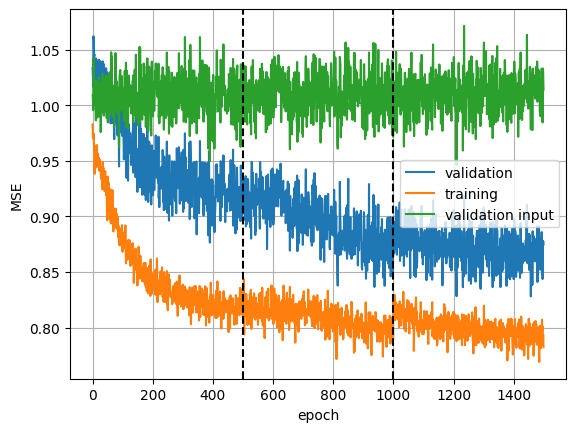

In [12]:
plt.plot(rec['validate_epoch'], rec['validate_mse'], label='validation')
plt.plot(rec['train_epoch'], rec['train_mse'], label='training')
plt.plot(rec['validate_epoch'], rec['raw_mse'], label='validation input')
plt.legend()
plt.grid()
plt.axvline(500, ls='--', c='k')
plt.axvline(1000, ls='--', c='k')
plt.xlabel('epoch')
plt.ylabel('MSE')

In [13]:
mse_df = pd.DataFrame({'epoch': rec['validate_epoch'], 'mse': rec['validate_mse']})

def epoch2stage(x):
    if x < 250: return 'pre-denoise'
    elif x < 500: return 'denoise'
    elif x < 750: return 'pre-denoise-smooth'
    elif x < 1000: return 'denoise-smooth'
    elif x < 1250: return 'pre-denoise-smooth-enhance'
    elif x < 1500: return 'denoise-smooth-enhance'
    else: raise NotImplementedError('x >= 1500 not allowed')

mse_df['stage'] = mse_df['epoch'].apply(epoch2stage)
mse_df

,epoch,mse,stage
0,0,1.033650,pre-denoise
1,1,1.028245,pre-denoise
2,2,1.016898,pre-denoise
3,3,1.062275,pre-denoise
4,4,1.058296,pre-denoise
...,...,...,...
1495,1495,0.877389,denoise-smooth-enhance
1496,1496,0.843669,denoise-smooth-enhance
1497,1497,0.872213,denoise-smooth-enhance
1498,1498,0.877829,denoise-smooth-enhance


/home/caoyufan/miniconda3/envs/kuanglu/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/caoyufan/miniconda3/envs/kuanglu/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/caoyufan/miniconda3/envs/kuanglu/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


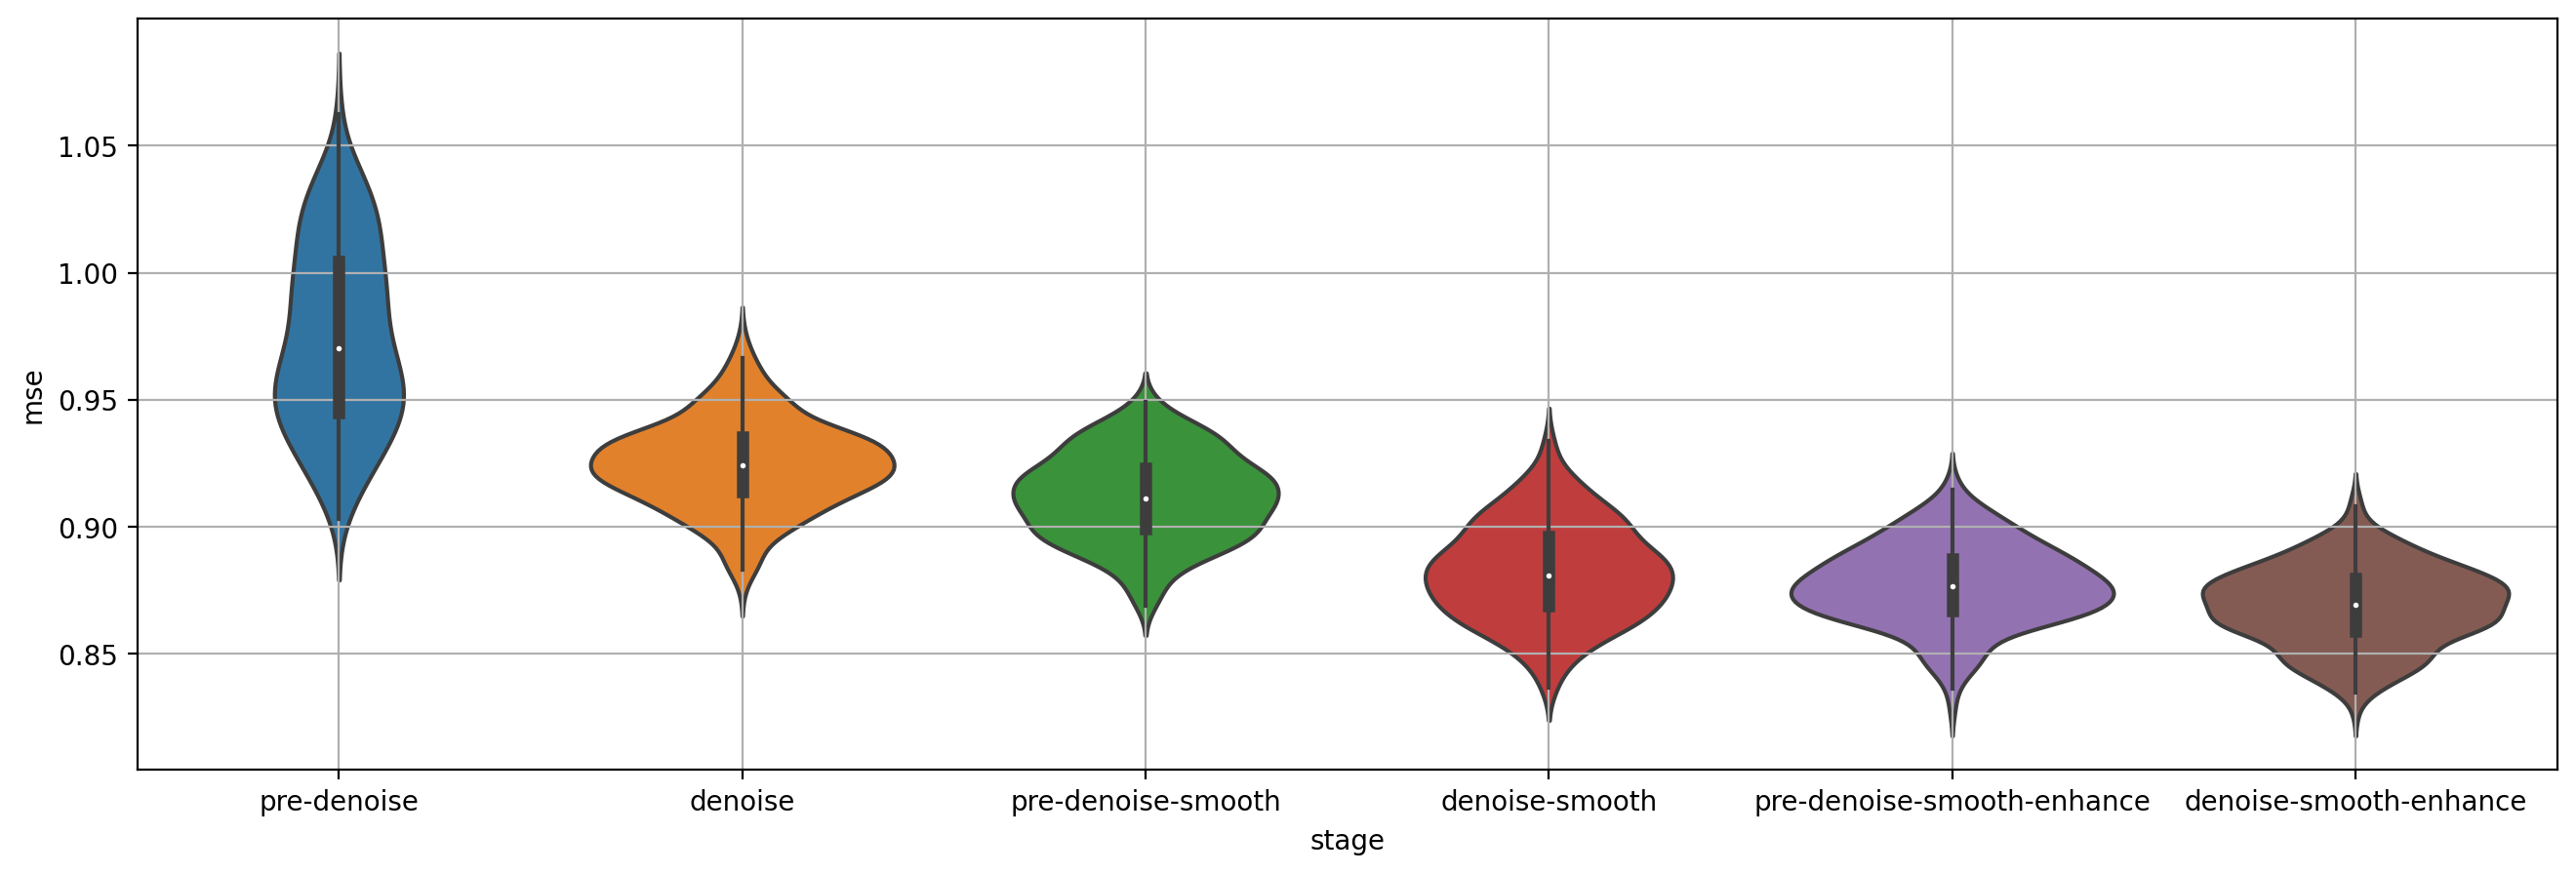

In [14]:
# sns.violinplot(mse_df[~mse_df['stage'].str.contains('pre-')], x='stage', y='mse')
%config InlineBackend.figure_format ='retina'
plt.figure(figsize=(16, 5))
sns.violinplot(mse_df, x='stage', y='mse')
plt.grid()

In [15]:
u_stat, p_val = sp.stats.mannwhitneyu(mse_df.loc[mse_df['stage'] == 'denoise', 'mse'], 
                      mse_df.loc[mse_df['stage'] == 'denoise-smooth', 'mse'])

print('p =', p_val, 
      'f =', u_stat / sum(mse_df['stage'] == 'denoise') / sum(mse_df['stage'] == 'denoise-smooth'))

p = 1.0998671653013286e-66 f = 0.9458719999999999


In [16]:
u_stat, p_val = sp.stats.mannwhitneyu(mse_df.loc[mse_df['stage'] == 'denoise-smooth', 'mse'], 
                      mse_df.loc[mse_df['stage'] == 'denoise-smooth-enhance', 'mse'])
print('p =', p_val, 
      'f =', u_stat / sum(mse_df['stage'] == 'denoise-smooth') / sum(mse_df['stage'] == 'denoise-smooth-enhance'))

p = 1.816157089317001e-14 f = 0.698064


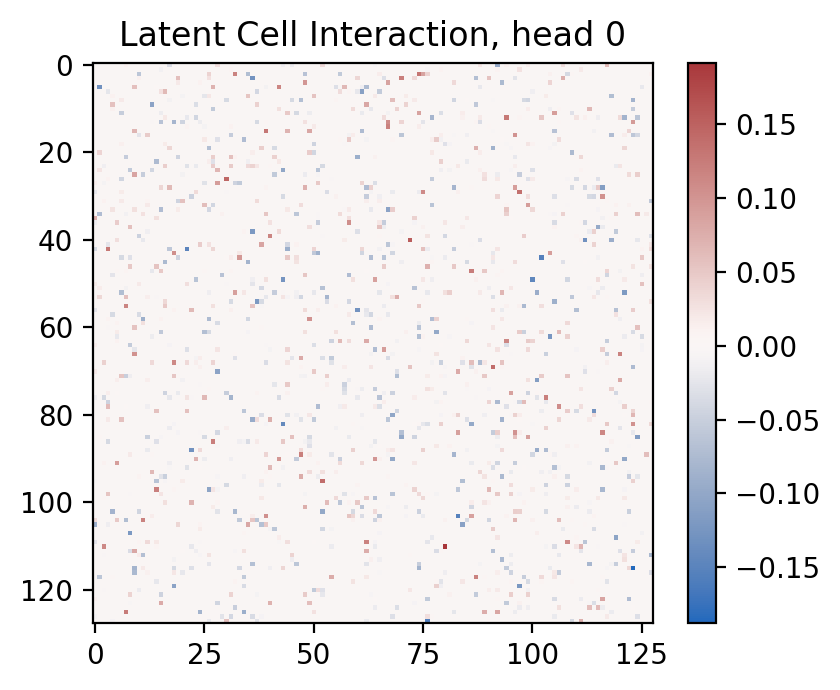

In [17]:
# Plot heatmap of the parameters in cell interaction module

weight_CIs = []
for head in range(len(model.cell_interacts)):
    weight_CIs.append(model.cell_interacts[head].transform.data)

plt.figure(figsize=(10, 8))
for i, weight_CI in enumerate(weight_CIs):
    weight_array = weight_CI.cpu().numpy()
    plt.subplot(2, 2, i + 1)
    plt.imshow(weight_array, cmap='vlag')
    plt.colorbar()
    plt.title(f'Latent Cell Interaction, head {i}')
plt.show()

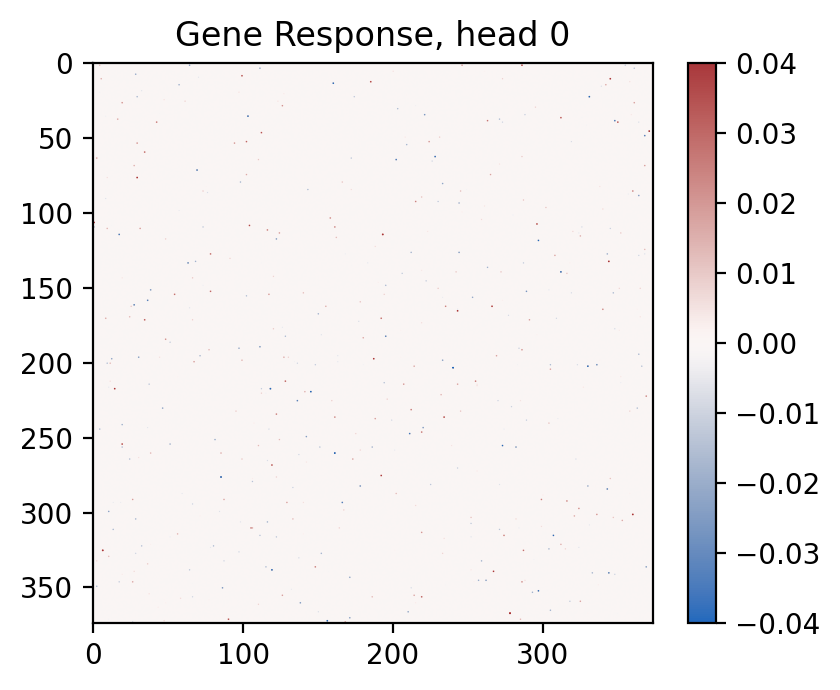

In [18]:
# Plot heatmap of the parameters in gene response module

weight_GRs = []
for head in range(len(model.cell_interacts)):
    weight_GRs.append(model.cell_interacts[head].gene_response.data)

plt.figure(figsize=(10, 8))
for i, weight_GR in enumerate(weight_GRs):
    weight_array = weight_GR.cpu().numpy()
    plt.subplot(2, 2, i + 1)
    plt.imshow(weight_array, cmap='vlag', vmin=-.04, vmax=.04)
    plt.colorbar()
    plt.title(f'Gene Response, head {i}')
plt.show()

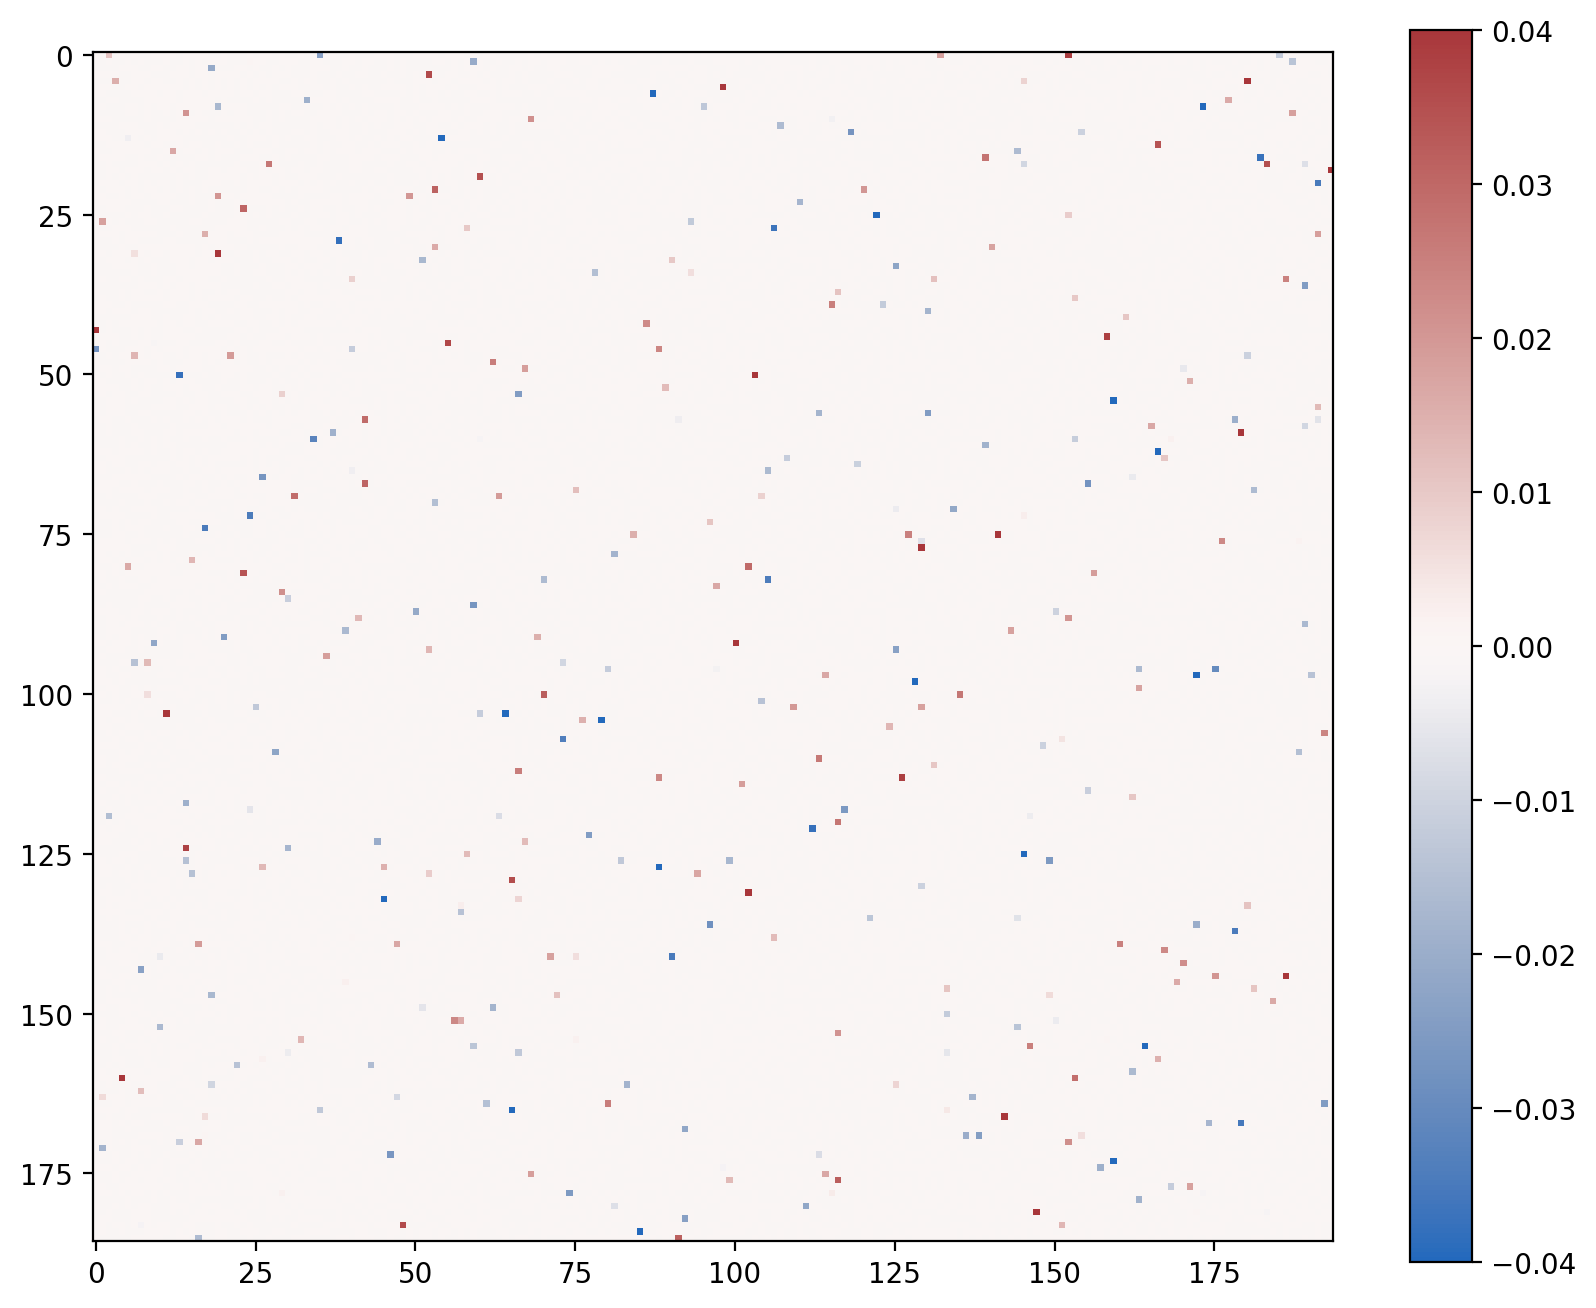

In [19]:
# Extract meaningful weights from Gene Response
THRESHOLD = 0.01

matGR = model.cell_interacts[0].gene_response.data.cpu().numpy()
col_max = np.max(np.abs(matGR), axis=0)
row_max = np.max(np.abs(matGR), axis=1)

meaningfulCols = np.where(col_max > THRESHOLD)[0]
meaningfulRows = np.where(row_max > THRESHOLD)[0]

meaningfulMatGR = matGR[meaningfulRows, :][:, meaningfulCols]

# meaningfulMatGR = np.clip(meaningfulMatGR, -.04, .04)

plt.figure(figsize=(10, 8))
plt.imshow(meaningfulMatGR, cmap='vlag', vmin=-.04, vmax=.04)
plt.colorbar()

In [20]:
# Find the indices of highest absolute values in the meaningfulMatGR

topK = 10
topK_indices = np.argsort(np.abs(matGR), axis=None)[-topK:]

topK_indices = np.unravel_index(topK_indices, matGR.shape)

topK_indices

(array([372, 301, 260, 276, 217, 114, 325, 203, 106, 367]),
 array([156, 360, 161,  85, 118, 193,   6, 240,   0, 278]))

In [21]:
np.abs(matGR)[topK_indices]

array([0.05168612, 0.05213824, 0.05491908, 0.05510096, 0.05790636,
       0.06242085, 0.06273259, 0.06375536, 0.07765445, 0.08281588],
      dtype=float32)

In [22]:
# check the corresponding genes

LR_pairs = []

for i in range(topK):
    LR_pairs.append((adata.var.index[topK_indices[1][i]], 
                     adata.var.index[topK_indices[0][i]]))

LR_pairs

[('ENSMUSG00000052609', 'ENSMUSG00000024501'),
 ('ENSMUSG00000028370', 'ENSMUSG00000005583'),
 ('ENSMUSG00000026395', 'ENSMUSG00000054555'),
 ('ENSMUSG00000020932', 'ENSMUSG00000052477'),
 ('ENSMUSG00000003184', 'ENSMUSG00000021061'),
 ('ENSMUSG00000007877', 'ENSMUSG00000000869'),
 ('ENSMUSG00000038115', 'ENSMUSG00000054509'),
 ('ENSMUSG00000047759', 'ENSMUSG00000047907'),
 ('ENSMUSG00000018381', 'ENSMUSG00000039217'),
 ('ENSMUSG00000024066', 'ENSMUSG00000038872')]

In [23]:
import pandas as pd

lr_pairs = pd.read_csv('./mouse_lr_pair.csv')

lgID = lr_pairs['ligand_ensembl_gene_id']
rpID = lr_pairs['receptor_ensembl_gene_id']

lrID = pd.concat([lgID, rpID], axis=1)
# lrID

geneIDBank = set(adata.var.index)

# filter out the genes that are not in the dataset

lrID = lrID[lrID['ligand_ensembl_gene_id'].isin(geneIDBank) &
            lrID['receptor_ensembl_gene_id'].isin(geneIDBank)]
lrID

,ligand_ensembl_gene_id,receptor_ensembl_gene_id
26,ENSMUSG00000035385,ENSMUSG00000049103
50,ENSMUSG00000000869,ENSMUSG00000026770
52,ENSMUSG00000000869,ENSMUSG00000031304
275,ENSMUSG00000017344,ENSMUSG00000026768
323,ENSMUSG00000019772,ENSMUSG00000022206
334,ENSMUSG00000019997,ENSMUSG00000020122
339,ENSMUSG00000019997,ENSMUSG00000030786
467,ENSMUSG00000024164,ENSMUSG00000026616
469,ENSMUSG00000024164,ENSMUSG00000030724
470,ENSMUSG00000024164,ENSMUSG00000030786


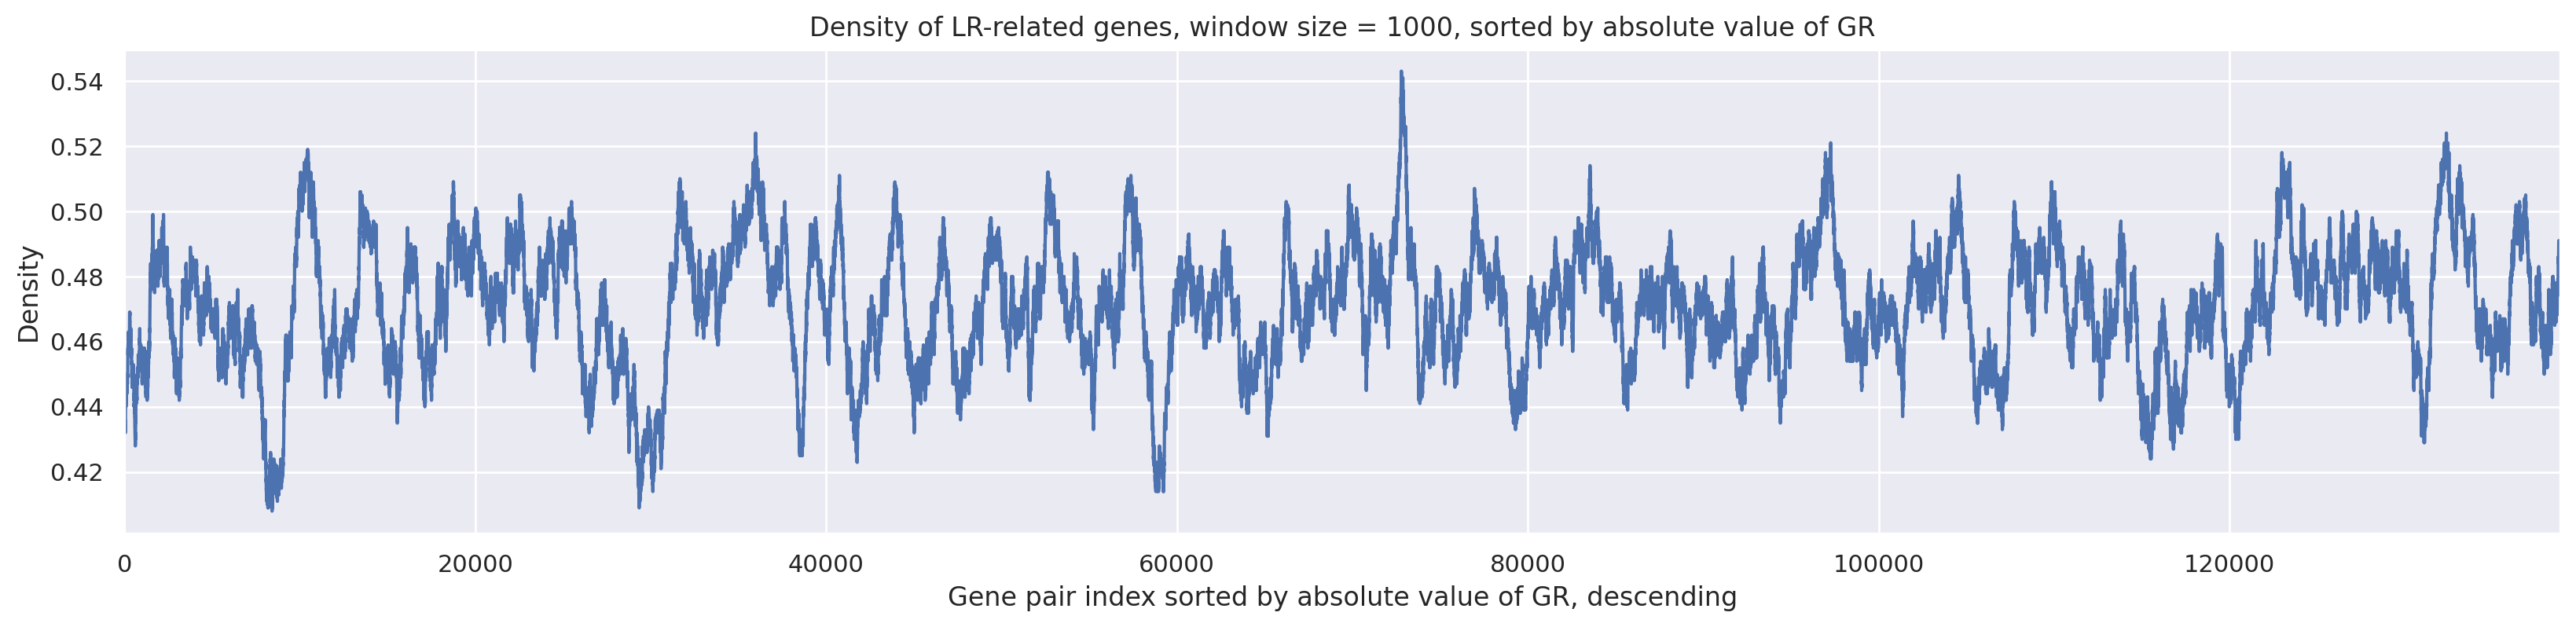

In [24]:
ranked_indices = np.argsort(np.abs(matGR), axis=None)
ranked_indices = np.unravel_index(ranked_indices, matGR.shape)

LR_related_genes = set(lgID) | set(rpID)

hasRelatedGenes = []

for indices in zip(ranked_indices[0], ranked_indices[1]):
    cnt = 0
    if adata.var.index[indices[0]] in LR_related_genes:
        cnt += 1
    if adata.var.index[indices[1]] in LR_related_genes:
        cnt += 1
    hasRelatedGenes.append(cnt)

hasRelatedGenes = np.array(hasRelatedGenes)

WINDOW_SIZE = 1000

density = []

for i in range(len(hasRelatedGenes) - WINDOW_SIZE):
    density.append(np.mean(hasRelatedGenes[i:i + WINDOW_SIZE]))
    
%config InlineBackend.figure_format ='retina'
sns.set()
plt.figure(figsize=(20, 4));
plt.plot(density);
plt.title(f'Density of LR-related genes, window size = {WINDOW_SIZE}, sorted by absolute value of GR');
plt.xlim(0, len(hasRelatedGenes) - WINDOW_SIZE);
plt.xlabel('Gene pair index sorted by absolute value of GR, descending');
plt.ylabel('Density');

In [25]:
genesCol = adata.var_names[meaningfulCols]
genesRow = adata.var_names[meaningfulRows]

genesCol, genesRow

(Index(['ENSMUSG00000018381', 'ENSMUSG00000020178', 'ENSMUSG00000017390',
        'ENSMUSG00000036777', 'ENSMUSG00000038115', 'ENSMUSG00000024411',
        'ENSMUSG00000060802', 'ENSMUSG00000048251', 'ENSMUSG00000031375',
        'ENSMUSG00000021835',
        ...
        'ENSMUSG00000031997', 'ENSMUSG00000026083', 'ENSMUSG00000028370',
        'ENSMUSG00000031839', 'ENSMUSG00000045875', 'ENSMUSG00000055761',
        'ENSMUSG00000020160', 'ENSMUSG00000050711', 'ENSMUSG00000044647',
        'ENSMUSG00000024238'],
       dtype='object', length=194),
 Index(['ENSMUSG00000035783', 'ENSMUSG00000024397', 'ENSMUSG00000037010',
        'ENSMUSG00000024411', 'ENSMUSG00000048251', 'ENSMUSG00000021835',
        'ENSMUSG00000028487', 'ENSMUSG00000036887', 'ENSMUSG00000035385',
        'ENSMUSG00000030724',
        ...
        'ENSMUSG00000023868', 'ENSMUSG00000053007', 'ENSMUSG00000028370',
        'ENSMUSG00000040612', 'ENSMUSG00000020160', 'ENSMUSG00000038872',
        'ENSMUSG00000097648', 'ENSM

In [26]:
meaningfulMatGR.shape

(186, 194)

([<matplotlib.axis.YTick at 0x7fd864733190>,
 [Text(0, 0, 'ENSMUSG00000025584'),
  Text(0, 1, 'ENSMUSG00000037653'),
  Text(0, 2, 'ENSMUSG00000026770'),
  Text(0, 3, 'ENSMUSG00000037321'),
  Text(0, 4, 'ENSMUSG00000040543'),
  Text(0, 5, 'ENSMUSG00000041378'),
  Text(0, 6, 'ENSMUSG00000052609'),
  Text(0, 7, 'ENSMUSG00000032446'),
  Text(0, 8, 'ENSMUSG00000047759'),
  Text(0, 9, 'ENSMUSG00000018593')])

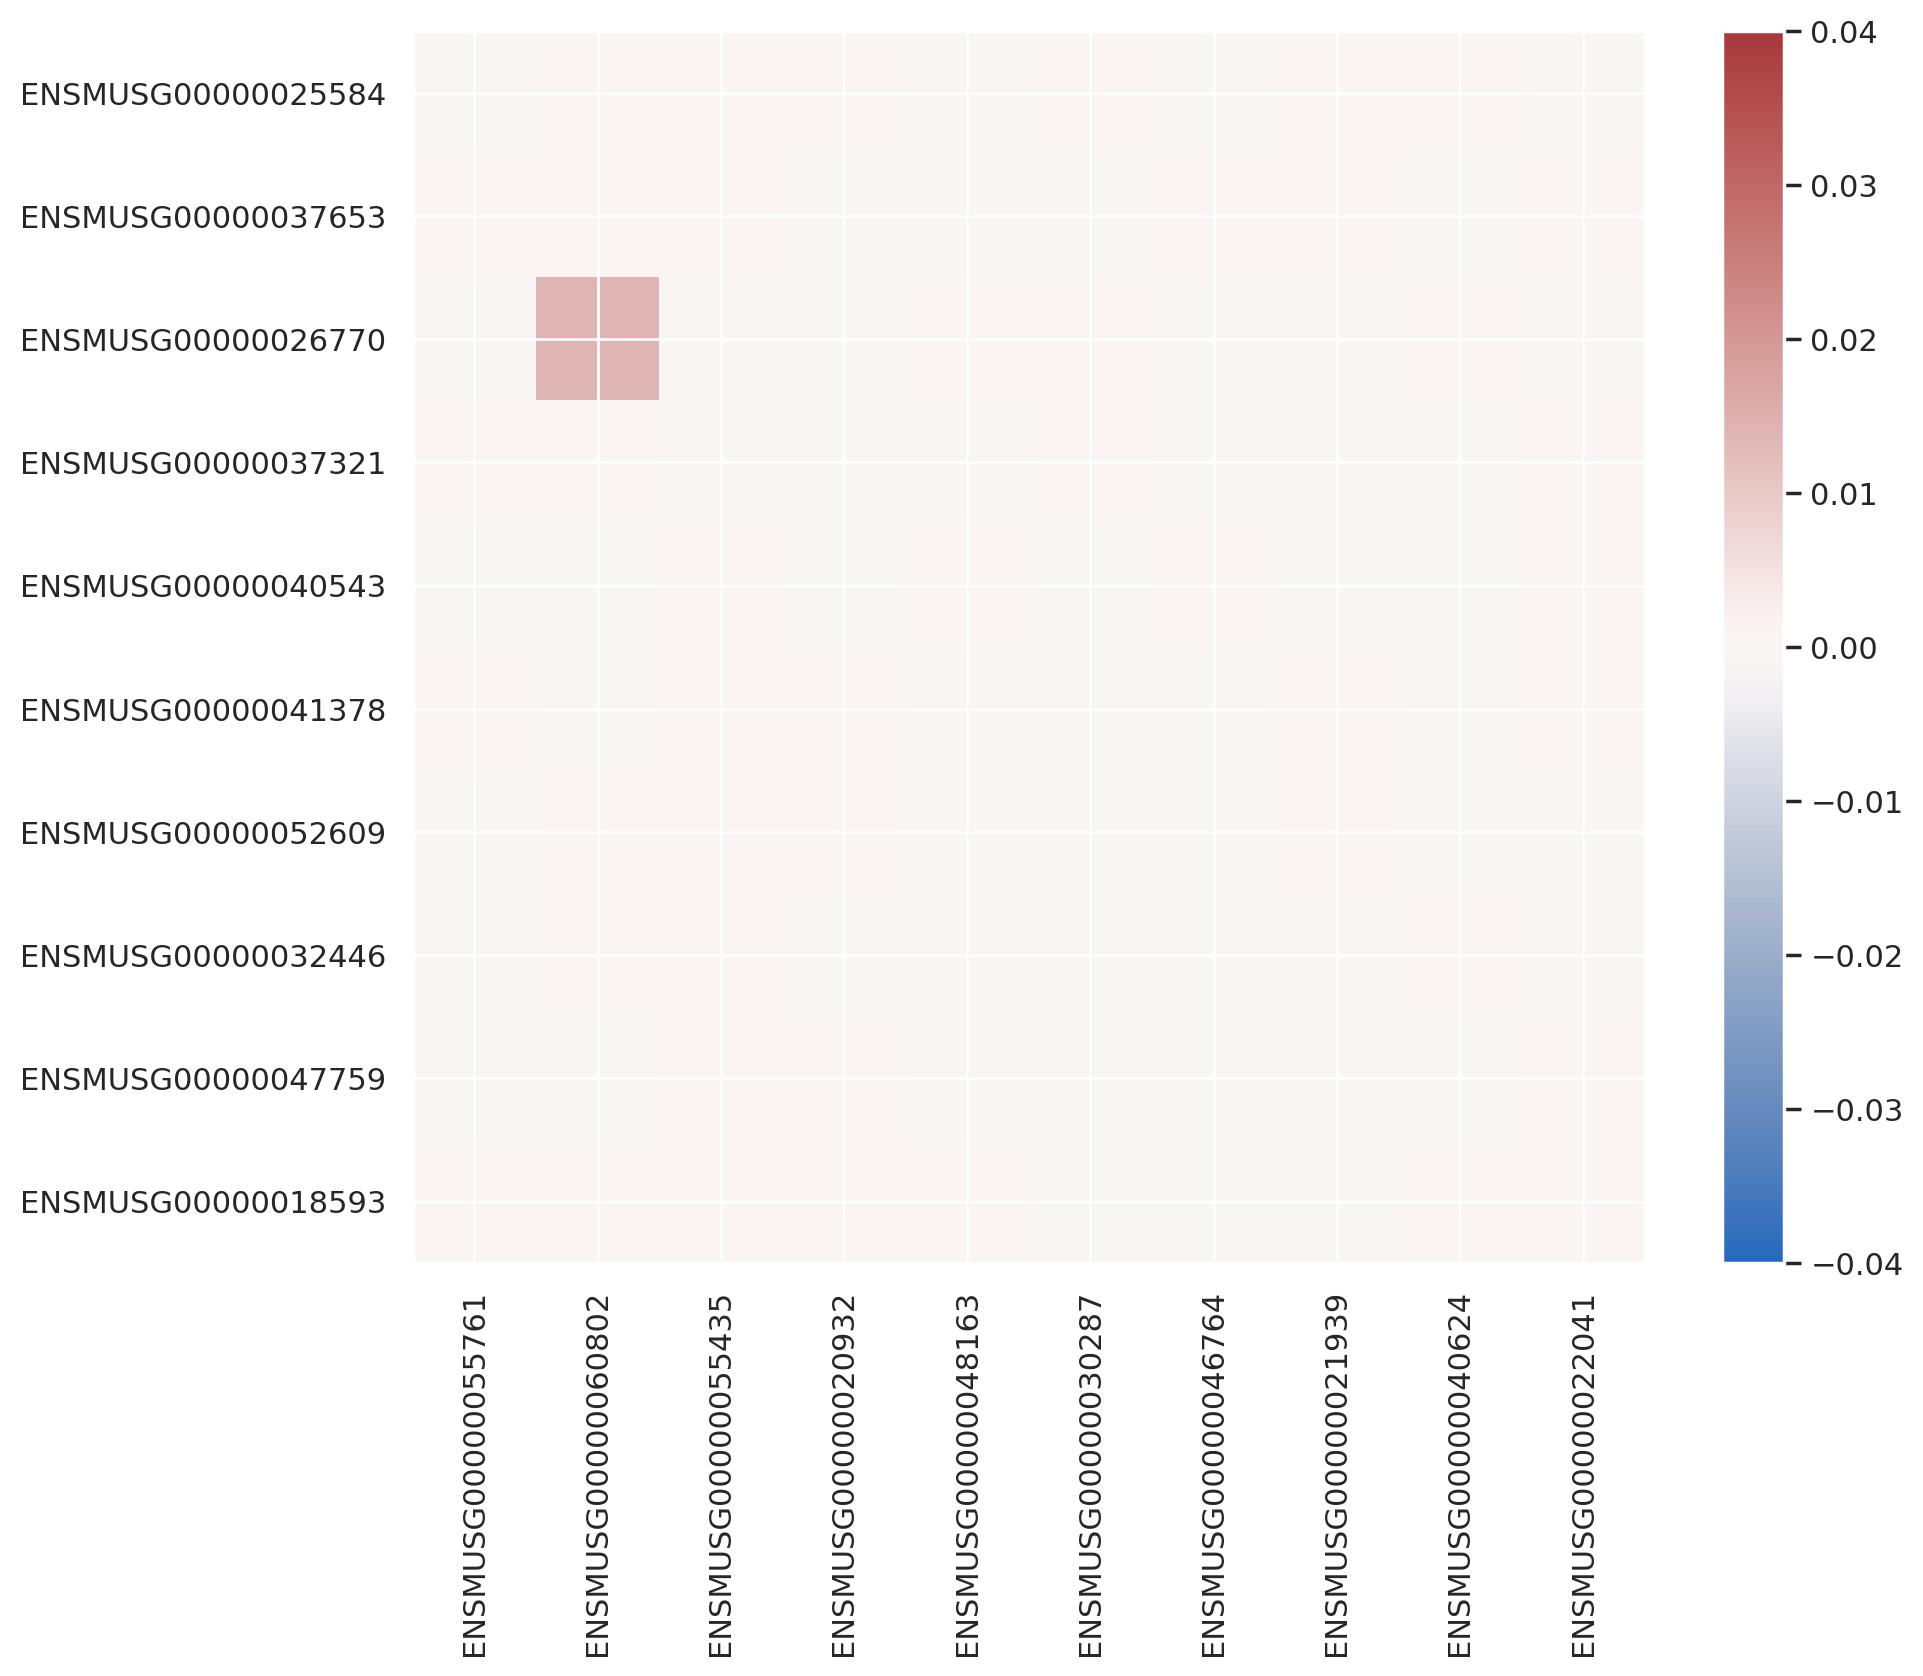

In [27]:
# take out a random patch

PATCH_SIZE = 10

idxCol = np.random.choice(meaningfulMatGR.shape[1], size=PATCH_SIZE, replace=False)
idxRow = np.random.choice(meaningfulMatGR.shape[0], size=PATCH_SIZE, replace=False)

patchMatGR = meaningfulMatGR[idxRow, :][:, idxCol]
patchGeneCol = genesCol[idxCol]
patchGeneRow = genesRow[idxRow]

plt.figure(figsize=(10, 8))
plt.imshow(patchMatGR, cmap='vlag', vmin=-.04, vmax=.04)
plt.colorbar()
plt.xticks(range(PATCH_SIZE), patchGeneCol, rotation=90)
plt.yticks(range(PATCH_SIZE), patchGeneRow)

In [28]:
# # take out a random column

# randColIdx = np.random.choice(meaningfulMatGR.shape[1], size=1, replace=False)
# randCol = meaningfulMatGR[:, randColIdx]
# randGene = genesCol[randColIdx]
# meaningfulY = np.abs(randCol) > THRESHOLD

# randCol = randCol[meaningfulY]

# randGene = randGene[meaningfulY]

# plt.figure(figsize=(10, 8))
# plt.imshow(randCol, cmap='vlag', vmin=-.04, vmax=.04)
# plt.colorbar()
# plt.xticks(range(1), randGene, rotation=90)
# plt.yticks(range(meaningfulMatGR.shape[0]), genesRow)

In [29]:
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"
